In [1]:
from src.utils import ham10000_metadata, get_model_dir, full_name_to_short_dict
import src.config as config
import matplotlib.pyplot as plt

ham10000_metadata

,Unnamed: 0,image_id,ruler,sticker,ink,lesion_id,dx,dx_type,age,sex,localization
0,0,ISIC_0024306,0.0,0.0,0.0,HAM_0000550,nv,follow_up,45.0,male,trunk
1,1,ISIC_0024307,0.0,0.0,0.0,HAM_0003577,nv,follow_up,50.0,male,lower extremity
2,2,ISIC_0024308,0.0,0.0,0.0,HAM_0001477,nv,follow_up,55.0,female,trunk
3,3,ISIC_0024309,0.0,0.0,0.0,HAM_0000484,nv,follow_up,40.0,male,trunk
4,4,ISIC_0024310,1.0,0.0,0.0,HAM_0003350,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...,...,...,...,...
10010,10010,ISIC_0034316,0.0,0.0,0.0,HAM_0004304,mel,histo,85.0,male,upper extremity
10011,10011,ISIC_0034317,0.0,0.0,0.0,HAM_0006376,mel,histo,70.0,female,lower extremity
10012,10012,ISIC_0034318,0.0,0.0,0.0,HAM_0000344,bkl,histo,55.0,male,trunk
10013,10013,ISIC_0034319,0.0,0.0,0.0,HAM_0000747,nv,histo,30.0,male,trunk


<AxesSubplot:xlabel='ruler', ylabel='localization'>

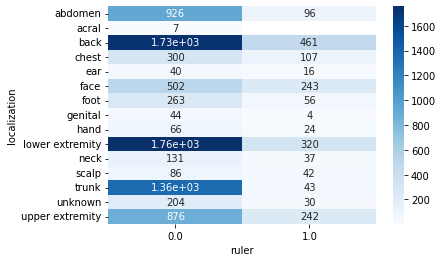

In [2]:
from src.utils import plot_prediction_confusion_matrix

plot_prediction_confusion_matrix(ham10000_metadata, 'localization', 'ruler')

Text(0.5, 45.722222222222214, 'Classification')

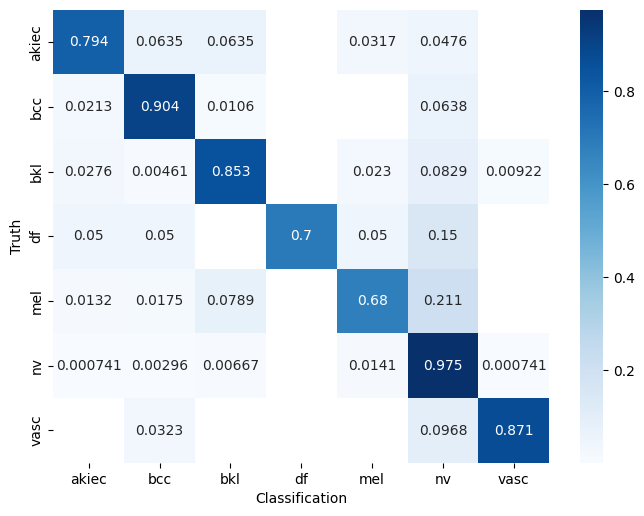

In [3]:
import pandas as pd

model_dir = get_model_dir(config.resnet_mixup_id)

df_standard = pd.read_csv(f"{model_dir}/predictions.csv").merge(
    ham10000_metadata, on="image_id"
)
df_standard["classification_short"] = df_standard.classification.map(
    lambda x: full_name_to_short_dict[x]
)
plt.figure(figsize=(8, 6), dpi=100)
p = plot_prediction_confusion_matrix(df_standard, 'dx', 'classification_short', normalize='x')
p.set_ylabel('Truth')
p.set_xlabel('Classification')


Text(0.5, 45.722222222222214, 'Classification')

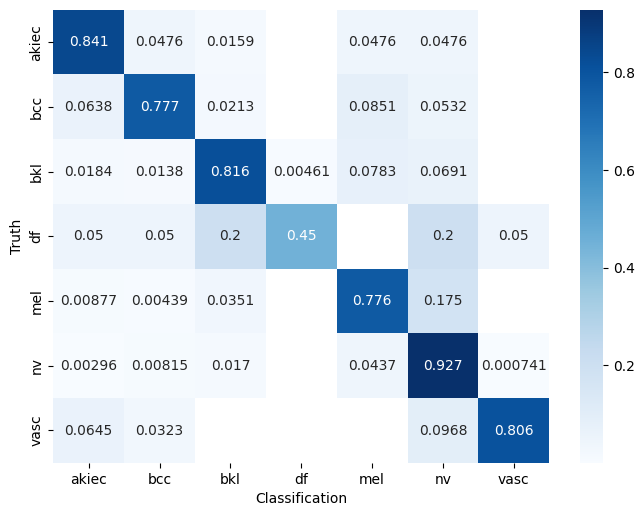

In [4]:
model_dir = get_model_dir(config.only_lesion_id)

df_only_lesions = pd.read_csv(f"{model_dir}/predictions.csv").merge(
    ham10000_metadata, on="image_id"
)
df_only_lesions["classification_short"] = df_only_lesions.classification.map(
    lambda x: full_name_to_short_dict[x]
)
plt.figure(figsize=(8, 6), dpi=100)
p = plot_prediction_confusion_matrix(df_only_lesions, 'dx', 'classification_short', normalize='x')
p.set_ylabel('Truth')
p.set_xlabel('Classification')

In [5]:
import sklearn.metrics as metrics
import sklearn.preprocessing

model_dir = get_model_dir(config.resnet_mixup_id)

df_standard = pd.read_csv(f"{model_dir}/predictions.csv").merge(
    ham10000_metadata, on="image_id"
)
df_standard["classification_short"] = df_standard.classification.map(
    lambda x: full_name_to_short_dict[x]
)


def balanced_accuracy(df, truth, prediction):
    """
    Compute balanced accuracy for a given MULTICLASS truth and prediction.
    """
    return metrics.balanced_accuracy_score(df[truth], df[prediction])




print(
    f"Balanced accuracy: {balanced_accuracy(df_standard, 'dx', 'classification_short'):.8f}"
)

int_encoder = sklearn.preprocessing.LabelEncoder()
int_encoder.fit(df_standard.dx)

print("Classification report:")
report = metrics.classification_report(
    int_encoder.transform(df_standard.dx),
    int_encoder.transform(df_standard.classification_short),
    target_names=int_encoder.classes_,
    output_dict=True,
)

# Turn the dict report into LaTeX
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: f"{x}")
report


Balanced accuracy: 0.82514968
Classification report:


,precision,recall,f1-score,support
akiec,0.793651,0.793651,0.793651,63.000000
bcc,0.850000,0.904255,0.876289,94.000000
bkl,0.852535,0.852535,0.852535,217.000000
df,1.000000,0.700000,0.823529,20.000000
mel,0.851648,0.679825,0.756098,228.000000
nv,0.942019,0.974815,0.958136,1350.000000
vasc,0.900000,0.870968,0.885246,31.000000
accuracy,0.914628,0.914628,0.914628,0.914628
macro avg,0.884265,0.825150,0.849355,2003.000000
weighted avg,0.912981,0.914628,0.912211,2003.000000


In [6]:
print("Confusion matrix:")
print(
    metrics.multilabel_confusion_matrix(
        df_standard.dx,
        df_standard.classification_short,
        labels=int_encoder.classes_,
    )
)

Confusion matrix:
[[[1927   13]
  [  13   50]]

 [[1894   15]
  [   9   85]]

 [[1754   32]
  [  32  185]]

 [[1983    0]
  [   6   14]]

 [[1748   27]
  [  73  155]]

 [[ 572   81]
  [  34 1316]]

 [[1969    3]
  [   4   27]]]


In [7]:
from src.utils import bening_or_malignant_dict

metrics.f1_score(
    df_standard.dx.map(lambda x: bening_or_malignant_dict[x]),
    df_standard.classification_short.map(lambda x: bening_or_malignant_dict[x]),
    average='macro',
)

0.8994932008630638

In [8]:
# AUC can't be calculated, since we don't have prediction strengths for binary
# metrics.auc(
#     df_standard.dx.map(lambda x: bening_or_malignant_dict[x]),
#     df_standard.classification_short.map(lambda x: bening_or_malignant_dict[x]),
# )

In [9]:
from src.utils import get_resnet_mixup_model

learn = get_resnet_mixup_model()
model = learn.model

/home/mbg/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/mbg/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


DEVICE: cpu


/home/mbg/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
from torch import nn
import torch
import torchvision.transforms as transforms
import os
from PIL import Image
# list(model.modules())[0] has length 2, I think the second part is
# the layer that is adapting to the specific classes.
# We are interested in the first part - the convolutional layers.


# Make a model that only extracts the features
print(list(model.children())[:-1])
extraction_model = nn.Sequential(
    #*(list(model.children())[:-1])
    *(list(model.children())[:-1])
)

def extract_features(image_id):
    home_path = os.path.expanduser("~")
    image = Image.open(f"{home_path}/kaggle-data/HAM10000/HAM10000_images/{image_id}.jpg")
    image = image.convert("RGB")
    image = image.resize((450, 450))
    image_tensor = transforms.PILToTensor()(image)
    image_tensor = image_tensor.float()
    image_tensor = image_tensor.unsqueeze(0)

    with torch.no_grad():
        extraction_model.eval()
        return extraction_model(image_tensor)

extract_features(df_standard.image_id[0])[0].shape

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Co

torch.Size([512, 15, 15])

In [12]:
import numpy as np
from src.utils import bening_or_malignant_dict
#ruler_sample = df_standard[df_standard.ruler == 1].sample(400)
#no_ruler_sample = df_standard[df_standard.ruler == 0].sample(200)

# sample = ruler_sample.append(no_ruler_sample)
sample = df_standard.sample(1500)
ruler_sample = sample[sample.ruler == 1]
no_ruler_sample = sample[sample.ruler == 0]

features = { image_id: np.array(extract_features(image_id)[0]) for image_id in sample.image_id }
has_ruler = { image_id: 1 for image_id in ruler_sample.image_id }
has_ruler = { **has_ruler, **{ image_id: 0 for image_id in no_ruler_sample.image_id } }

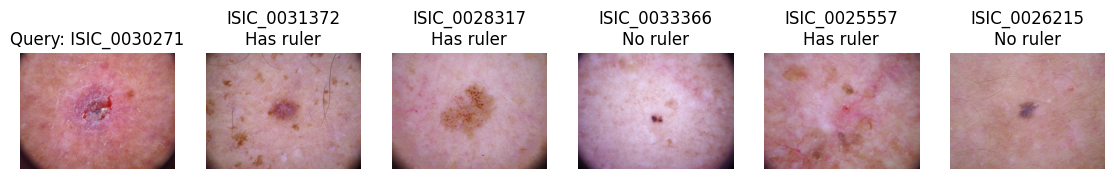

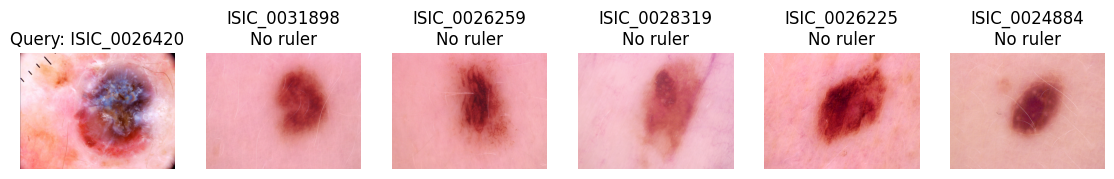

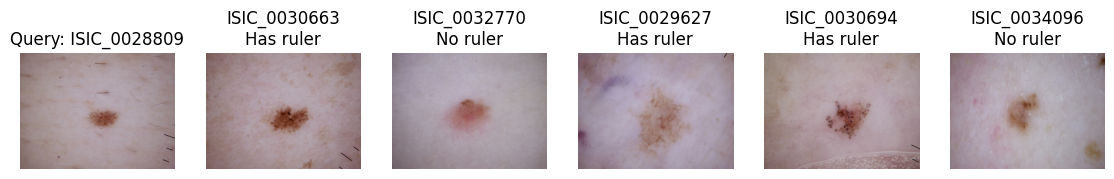

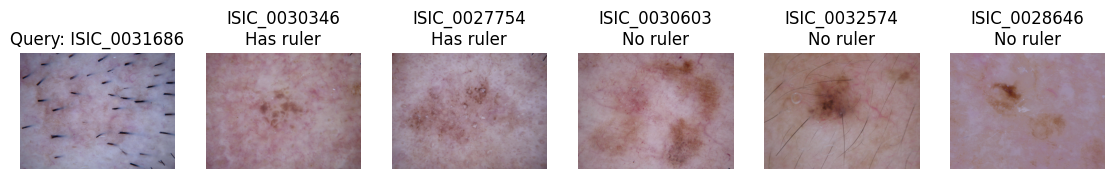

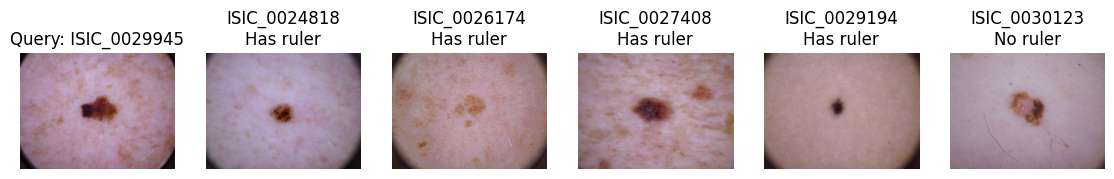

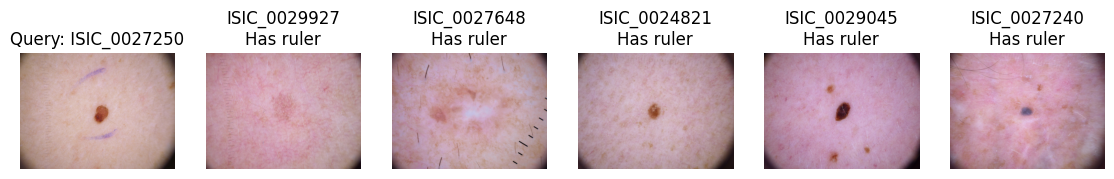

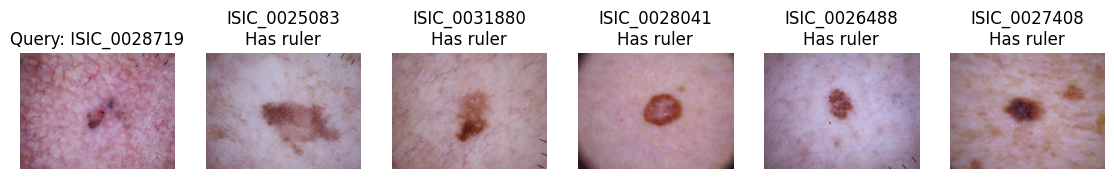

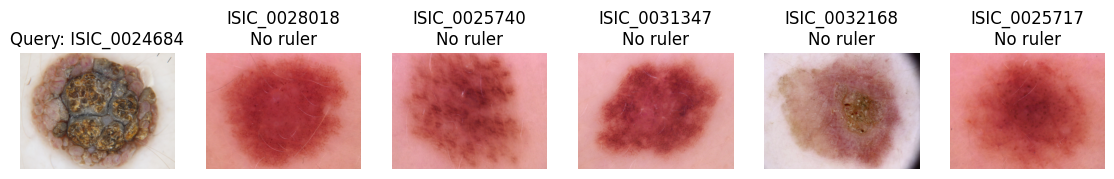

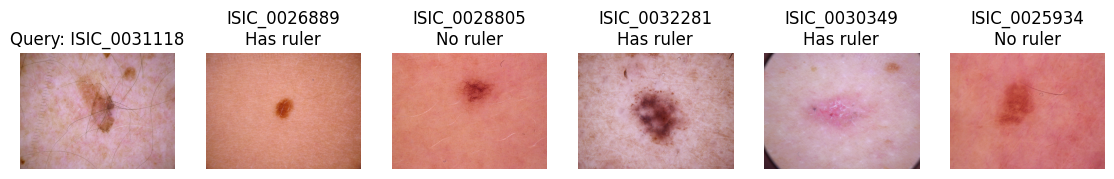

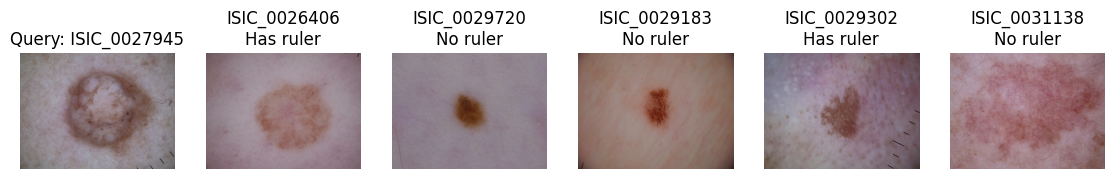

In [13]:
import seaborn as sns

# Get a random image from each of the two samples
ruler_examples = ruler_sample.sample(10, random_state=1337).image_id

home_path = os.path.expanduser("~")

for image_id in ruler_examples:
    image_vector = features[image_id]
    # Find the 5 nearest neighbors
    distances = {
        image_id: np.linalg.norm(image_vector - features[image_id])
        for image_id in features.keys()
    }
    nearest_neighbors = sorted(distances, key=distances.get)[1:6]
    # sorted(
    #     features.items(),
    #     key=lambda x: np.linalg.norm(x[1] - image_vector),
    #     reverse=True,
    # )[:5]
    # Plot the six images next to each other
    plt.figure(figsize=(14, 6), dpi=100)
    plt.subplot(1, 6, 1)
    plt.imshow(
        Image.open(f"{home_path}/kaggle-data/HAM10000/HAM10000_images/{image_id}.jpg")
    )
    plt.axis("off")
    plt.title(f"Query: {image_id}")
    for i, neighbor_id in enumerate(nearest_neighbors):
        plt.subplot(1, 6, i + 2)
        plt.imshow(
            Image.open(
                f"{home_path}/kaggle-data/HAM10000/HAM10000_images/{neighbor_id}.jpg"
            )
        )
        # Remove the axis labels
        plt.axis("off")
        plt.title(
            f"{neighbor_id}\n{'Has ruler' if has_ruler[neighbor_id] else 'No ruler'}"
        )
    plt.show()

    if False:
        # Plot the distances between the query and the neighbors
        plt.figure(figsize=(14, 6), dpi=100)

        # Plot the distances for the ruler samples
        ruler_distances = [distances[image_id] for image_id in ruler_sample.image_id]
        no_ruler_distances = [distances[image_id] for image_id in no_ruler_sample.image_id]
        plot_df = pd.DataFrame(
            {
                "distances": ruler_distances + no_ruler_distances,
                "has_ruler": [1] * len(ruler_distances) + [0] * len(no_ruler_distances),
            }
        )
        sns.displot(data=plot_df, x="distances", hue="has_ruler", kind='kde')

In [14]:
# Perform PCA on the features
from sklearn.decomposition import PCA

ftrs = np.array(list((map(lambda x: np.reshape(x, (-1, 1)), features.values()))))
# Dimension is not (N, M, 1) - turn it into (N, M)
ftrs = np.array(list(map(lambda x: np.squeeze(x), ftrs)))
print(ftrs[0].shape)

PCA = PCA(n_components=2)
PCA.fit(list(ftrs))

features_pca = PCA.transform(list(ftrs))


(115200,)


In [15]:
df = pd.DataFrame(features_pca, columns=["x", "y"])
df["image_id"] = list(features.keys())
df["has_ruler"] = list(has_ruler.values())
# Get the dx from the image_id in the metadata
df["dx"] = df.image_id.map(lambda x: ham10000_metadata[ham10000_metadata.image_id == x].dx.values[0])
df["malignancy"] = df.dx.map(lambda x: bening_or_malignant_dict[x])
df

,x,y,image_id,has_ruler,dx,malignancy
0,-6798.359750,-3724.147660,ISIC_0024839,1,bkl,benign
1,16797.778053,-225.634056,ISIC_0024480,1,nv,benign
2,-1252.068190,-4785.828914,ISIC_0028805,1,nv,benign
3,-15188.146608,624.447447,ISIC_0030379,1,nv,benign
4,11843.889182,-6991.004341,ISIC_0033126,1,nv,benign
...,...,...,...,...,...,...
1495,9848.606745,4596.046343,ISIC_0031058,0,nv,benign
1496,21555.210112,-925.771666,ISIC_0033800,0,nv,benign
1497,-24414.282424,-2966.921624,ISIC_0032147,0,nv,benign
1498,930.691439,-5186.625257,ISIC_0026687,0,bcc,malignant


In [16]:
# Determine the number of malignant images
df_malignant = df[df.malignancy == 'malignant']
df_benign = df[df.malignancy == 'benign']
len(df_malignant), len(df_benign)

(284, 1216)

In [17]:
# Take an equal amount of malignant and benign images
# with an equal amount of ruler and no ruler in each
df_malignant_with_ruler = df_malignant[df_malignant.has_ruler == 1]
df_malignant_without_ruler = df_malignant[df_malignant.has_ruler == 0]
df_benign_with_ruler = df_benign[df_benign.has_ruler == 1]
df_benign_without_ruler = df_benign[df_benign.has_ruler == 0]

minimum_size = min(
    len(df_malignant_with_ruler),
    len(df_malignant_without_ruler),
    len(df_benign_with_ruler),
    len(df_benign_without_ruler),
)
# Take the minimum amount of images from each
df_malignant_with_ruler = df_malignant_with_ruler.sample(minimum_size)
df_malignant_without_ruler = df_malignant_without_ruler.sample(minimum_size)
df_benign_with_ruler = df_benign_with_ruler.sample(minimum_size)
df_benign_without_ruler = df_benign_without_ruler.sample(minimum_size)

df_sample = df_malignant_with_ruler.append(
    df_malignant_without_ruler.append(
        df_benign_with_ruler.append(
            df_benign_without_ruler
        )
    )
)
df_sample

,x,y,image_id,has_ruler,dx,malignancy
178,-18919.668598,6062.939173,ISIC_0026420,1,mel,malignant
243,1153.851796,9252.972605,ISIC_0030754,1,mel,malignant
88,-4580.634660,-8871.459796,ISIC_0024329,1,akiec,malignant
148,-2971.030812,23501.232601,ISIC_0027673,1,mel,malignant
92,25846.811726,-17225.909721,ISIC_0026275,1,bcc,malignant
...,...,...,...,...,...,...
967,561.014380,4992.781210,ISIC_0026542,0,nv,benign
1226,28193.571394,-8819.260338,ISIC_0024635,0,bkl,benign
1353,-13882.394472,11050.794909,ISIC_0031411,0,nv,benign
450,-28096.491544,-8680.782659,ISIC_0027554,0,nv,benign


<AxesSubplot:xlabel='x', ylabel='y'>

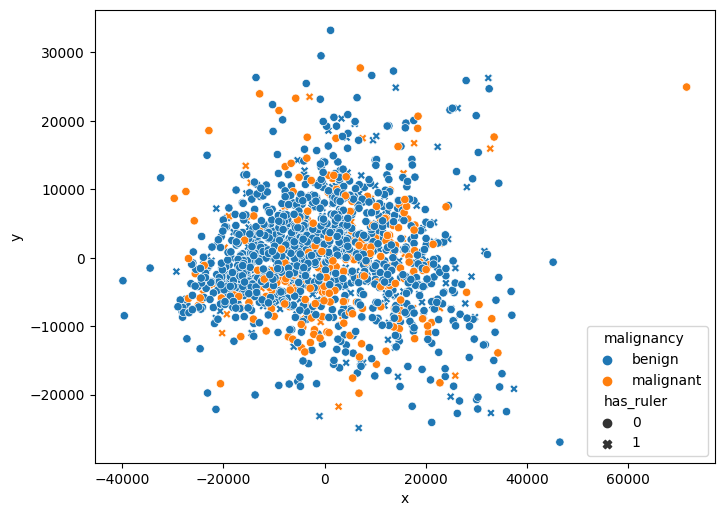

In [18]:

import seaborn as sns

plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x="x", y="y", style="has_ruler", data=df, hue="malignancy")

<Figure size 1800x600 with 0 Axes>

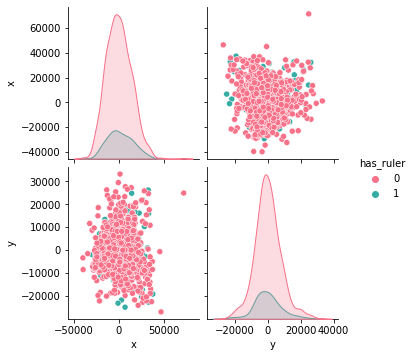

<Figure size 1800x600 with 0 Axes>

In [19]:
sns.pairplot(df, hue="has_ruler", palette="husl")
plt.figure(figsize=(18, 6), dpi=100)

<AxesSubplot:xlabel='x', ylabel='y'>

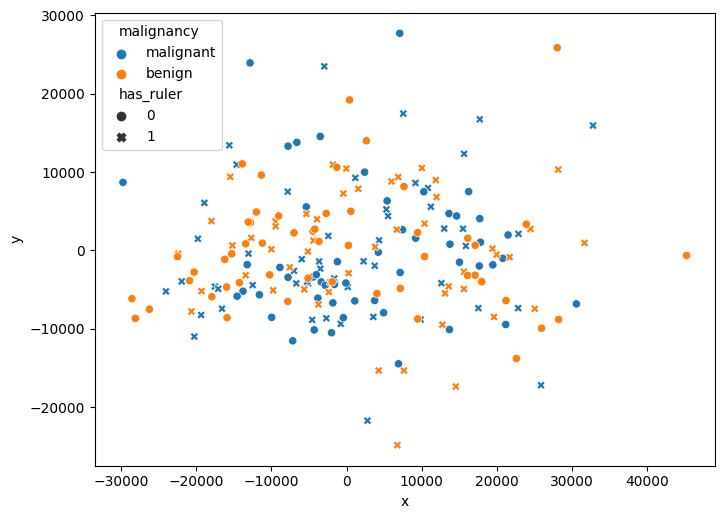

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x="x", y="y", style="has_ruler", data=df_sample, hue="malignancy")
